In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.io as sio 
import os
!pip install opencv-python
import cv2
!pip install tensorflow
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from collections import Counter

     |████████████████████████████████| 50.4 MB 51 kB/s s eta 0:00:01
     |████████████████████████████████| 394.4 MB 5.6 kB/s  eta 0:00:01
     |████████████████████████████████| 2.9 MB 59.7 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 10.6 MB 62.5 MB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 58.6 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 6.2 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 56.7 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 52.8 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 54.2 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 9.2 MB/s  eta 0:00:01
     |████████████████████████████████| 136 kB 58.0 MB/s eta 0:00:01
     |███████████████████████████

ModuleNotFoundError: No module named 'keras'

In [31]:
#define paths to use later
car_devkit=Path('../cars/stanford/car_devkit')
car_test=Path('../cars/stanford/cars_test/cars_test')
car_train=Path('../cars/stanford/cars_train/cars_train')

In [34]:

cars_metadata=sio.loadmat('../cars/stanford/car_devkit/devkit/cars_meta.mat')
cars_train_annos=sio.loadmat('../cars/stanford/car_devkit/devkit/cars_train_annos.mat')
cars_test_annos=sio.loadmat('../cars/stanford/car_devkit/devkit/cars_test_annos.mat')

In [205]:
cars_meta=[]
for x in cars_metadata['class_names'][0]:
    cars_meta.append(x)
    
cars_classes=pd.DataFrame(cars_meta,columns=['cars_classes_exist_in_data'])
cars_classes

,cars_classes_exist_in_data
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
...,...
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007


In [138]:
fname=[[x.flatten()[0] for x in i]  for i in cars_train_annos['annotations'][0]]
column_list=['bbox_x1','bbox_y1','bbox_x2','bbox_y2','class','fname']
train_df=pd.DataFrame(fname,columns=column_list)
train_df['class']=train_df['class'] - 1 ### all values start from zero because above class_classes df index for classes started from zero hence.
train_df['fname']=[car_train/i for i in train_df['fname']]
train_df=train_df.merge(cars_classes,left_on='class',right_index=True)
train_df=train_df.sort_index()
train_df

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,cars_classes_exist_in_data
0,39,116,569,375,13,../cars/stanford/cars_train/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,../cars/stanford/cars_train/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,../cars/stanford/cars_train/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,../cars/stanford/cars_train/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,../cars/stanford/cars_train/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012
...,...,...,...,...,...,...,...
8139,3,44,423,336,77,../cars/stanford/cars_train/cars_train/08140.jpg,Chrysler Town and Country Minivan 2012
8140,138,150,706,523,195,../cars/stanford/cars_train/cars_train/08141.jpg,smart fortwo Convertible 2012
8141,26,246,660,449,162,../cars/stanford/cars_train/cars_train/08142.jpg,Mercedes-Benz SL-Class Coupe 2009
8142,78,526,1489,908,111,../cars/stanford/cars_train/cars_train/08143.jpg,Ford GT Coupe 2006


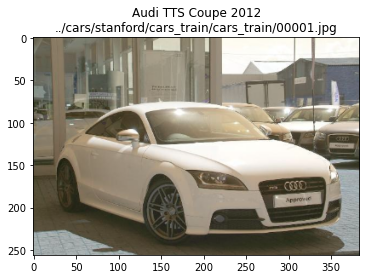

In [186]:
def peek_image(ax,input_row):
    image_name = input_row['cars_classes_exist_in_data']
    im = cv2.imread(str(input_row['fname']))
    w, h, ch = im.shape
    #print("orignal shape:" , w, h)
    h_resize = int(256*1.5)
    w_resize = 256
    im = cv2.resize(im,(h_resize,w_resize),interpolation=cv2.INTER_LINEAR)
    w, h, ch = im.shape
    #print("resized shape:" , w, h)
    ax.imshow(im)
    ax.set_title(image_name + f"\n{input_row['fname']}")
fig, ax = plt.subplots()
peek_image(ax, train_df.iloc[0])   


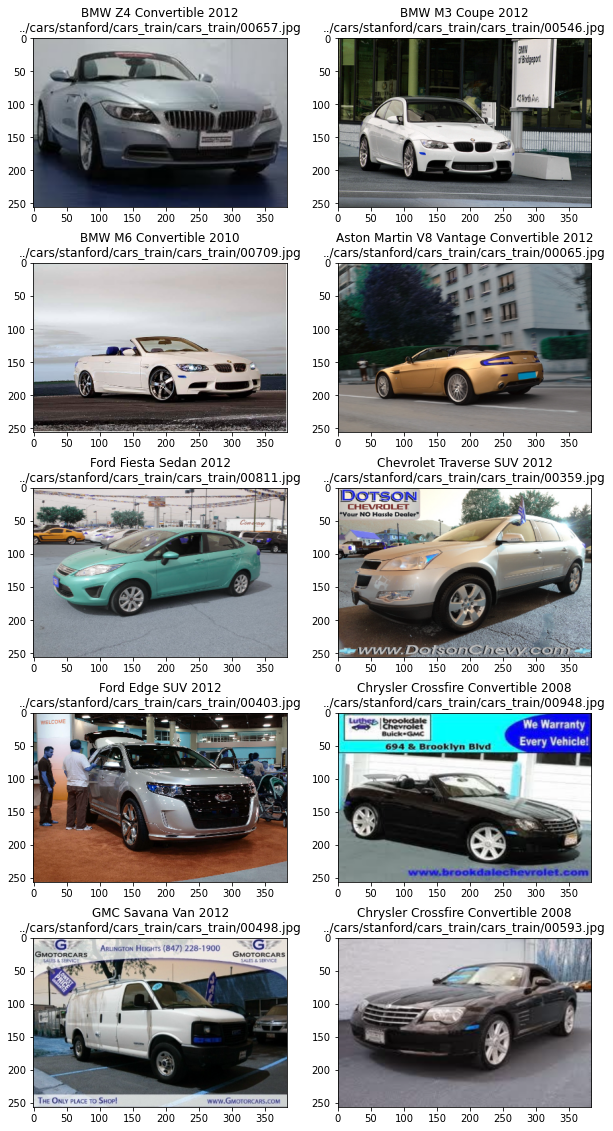

In [198]:
fig, axs = plt.subplots(5,2,figsize = (10,20))
for i, ax in zip(np.random.randint(0,1000, 10),axs.flatten()):
    peek_image(ax,train_df.iloc[i])

In [41]:
!unzip './Stanford Cars Dataset simplified.zip'

Archive:  ./Stanford Cars Dataset simplified.zip
  inflating: Audi/00001.jpg          
  inflating: Acura/00002.jpg         
  inflating: Dodge/00003.jpg         
  inflating: Hyundai/00004.jpg       
  inflating: Ford/00005.jpg          
  inflating: Geo/00006.jpg           
  inflating: Dodge/00007.jpg         
  inflating: Dodge/00008.jpg         
  inflating: Mitsubishi/00009.jpg    
  inflating: Chevrolet/00010.jpg     
  inflating: Buick/00011.jpg         
  inflating: Toyota/00012.jpg        
  inflating: Hyundai/00013.jpg       
  inflating: Dodge/00014.jpg         
  inflating: Volvo/00015.jpg         
  inflating: Plymouth/00016.jpg      
  inflating: Audi/00017.jpg          
  inflating: Chevrolet/00018.jpg     
  inflating: Volkswagen/00019.jpg    
  inflating: Chevrolet/00020.jpg     
  inflating: Chrysler/00021.jpg      
  inflating: BMW/00022.jpg           
  inflating: GMC/00023.jpg           
  inflating: Nissan/00024.jpg        
  inflating: Volvo/00025.jpg         
 

In [245]:
single_string = []
for names in train_df['cars_classes_exist_in_data'].values:
    last = names.split(' ')[-2:-1]
    single_string += last

In [323]:
train_df['target'] = 'None'

In [246]:
classes = []
for names in cars_classes['cars_classes_exist_in_data'].values:
    last = names.split(' ')[-2:-1]
    classes += last


Categories: Sedan, Van, Truck, Coupe, Convertible, SUV

EZ Categories: Car, Truck

In [243]:
S = train_df['cars_classes_exist_in_data']

In [251]:
set(single_string)

{'Abarth',
 'Cab',
 'Convertible',
 'Coupe',
 'GS',
 'Hatchback',
 'IPL',
 'Minivan',
 'R',
 'SRT-8',
 'SRT8',
 'SS',
 'SUV',
 'Sedan',
 'SuperCab',
 'Superleggera',
 'Type-S',
 'Van',
 'Wagon',
 'XKR',
 'Z06',
 'ZR1'}

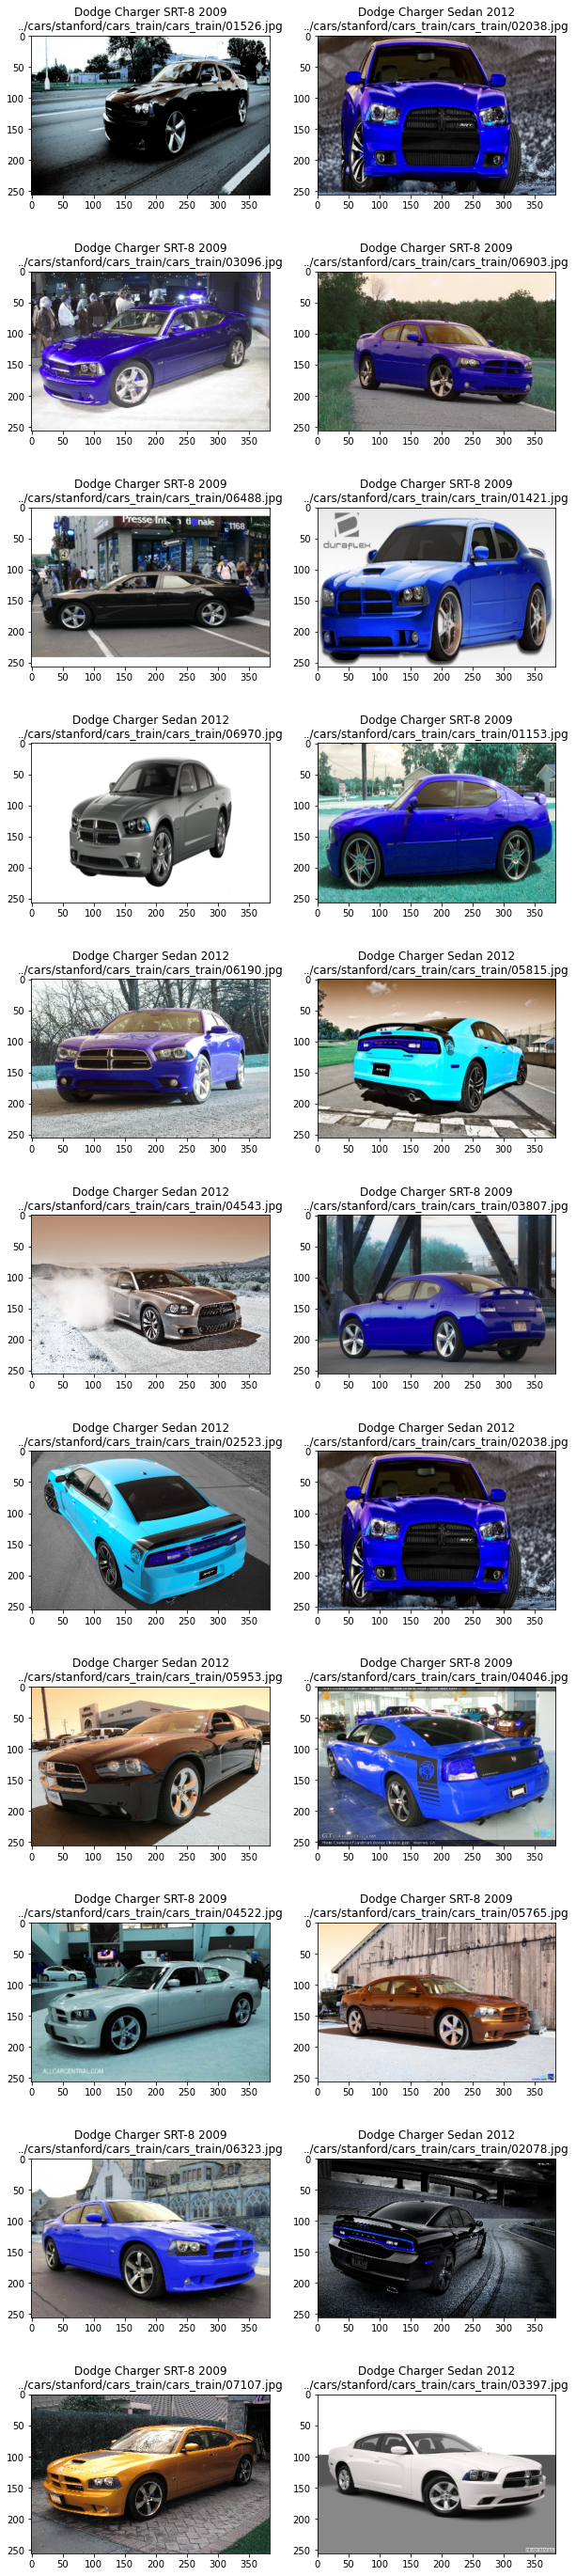

In [330]:
fig, axs = plt.subplots(11,2,figsize = (10,50))
for cl, ax in zip(set(single_string),axs.flatten()):
    peek_image(ax, train_df[S.str.contains('Charger')].sample().iloc[0])

In [331]:
class_changes = {'Sedan':['Chrysler 300', 'GS', 'Hatchback', 'Type-S', 'Sedan', 'Wagon','Charger'], 
                 'Van': ['Van', 'Minivan', 'HHR'], 
                 'Truck': ['Cab '], 
                 'Coupe': ['Challenger', 'Abarth', 'IPL', 'Type R', 'Cobalt SS', 'Lamborghini', 'XKR', 'Z06', 'ZR1', 'Coupe'], 
                 'Convertible': ['Convertible'], 
                 'SUV': ['TrailBlazer', 'SUV']}

In [332]:
for k, v in class_changes.items():
    for substr in v:
        train_df['target'][S.str.contains(substr)] = k
Counter(train_df['target'].values)

/home/hanzhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Counter({'Coupe': 1410,
         'Sedan': 2882,
         'Truck': 761,
         'Convertible': 1036,
         'SUV': 1477,
         'Van': 578})

In [334]:
set(train_df['target'].values)

{'Convertible', 'Coupe', 'SUV', 'Sedan', 'Truck', 'Van'}

In [335]:
# import os 
# import zipfile

# zf=zipfile.ZipFile('Stanford Cars Dataset simplified.zip',mode='w')

# try:
#     for i in train_df.index:
#         try:
#             name=train_df['cars_classes_exist_in_data'][i]
#             #print(name)
#             file_path=train_df['fname'][i]
#             file_name=os.path.basename(joined_df['fname'][i])
#             short_name=name.split(" ")[0]
#             zf.write(file_path,os.path.join(short_name,file_name),zipfile.ZIP_DEFLATED)
#         except Exception as exc:
#             print(str(exc))
#             pass
# finally:
#     print('closing')
#     zf.close()

closing
